In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station 

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Precipitation Analysis

In [13]:
# Find the most recent date in the data set.
latest = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(latest[0])

2017-08-23


In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
import datetime as dt
# Calculate the date one year from the last date in data set.
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(query_date)

# Perform a query to retrieve the data and precipitation scores

sel = [Measurement.date, Measurement.prcp]
result = session.query(*sel).filter(Measurement.date >= query_date).all()


# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
precip_df = pd.DataFrame(result, columns=["Date","Precipitation"]).set_index('Date')
# sort dates so they are in order on the chart
precip_df.sort_values(by='Date',ascending=True,inplace=True)

2016-08-23


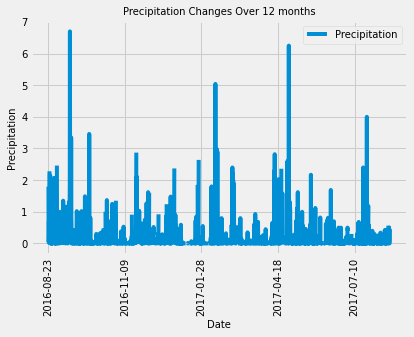

In [15]:
# plot the data to look (mostly) like the challenge image
precip_df.plot()
plt.title(f"Precipitation Changes Over 12 months", fontsize=10)
plt.xlabel("Date",fontsize=10)
plt.ylabel("Precipitation", fontsize=10)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(which='major', axis='both', linestyle='-')
plt.legend(fontsize=10)
plt.show()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number stations in the dataset
session.query
session.query(Station).count()

9

In [18]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
sel = [Measurement.station, func.count(Measurement.id)]
station_cts = session.query(*sel).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()
station_cts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
low = session.query(func.min(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()

high = session.query(func.max(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()

average = session.query(func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()

print(f"The lowest observed temp is: {low}")
print(f"The highest observed temp is: {high}")
print(f"The average observed temp is: {average}")

The lowest observed temp is: [(54.0,)]
The highest observed temp is: [(85.0,)]
The average observed temp is: [(71.66378066378067,)]


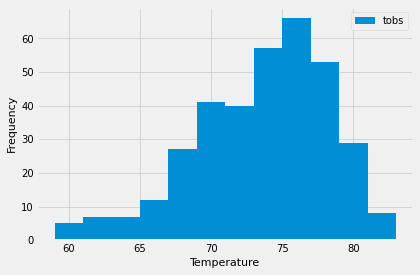

In [20]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
queryresult = session.query(Measurement.tobs).\
    filter(Measurement.station == station_cts[0][0]).\
    filter(Measurement.date >= query_date).all()
temperatures = list(np.ravel(queryresult))

sel = [Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation]
queryresult = session.query(*sel).all()
stations_desc = pd.DataFrame(queryresult, columns=['Station','Name','Latitude','Longitude','Elevation'])

stationname = stations_desc.loc[stations_desc["Station"] == station_cts[0][0],"Name"].tolist()[0]

# n, bins, patches = plt.hist(temperatures, bins=12,alpha=0.7, rwidth=1.0,label='tobs')
plt.hist(temperatures, bins=12,rwidth=1.0,label='tobs')
plt.grid(axis='both', alpha=0.75)
plt.xlabel('Temperature',fontsize=11)
plt.ylabel('Frequency',fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
#plt.title(f"Temperature from 8/23/2016 and 8/23/2017 observed at {stationname}")
plt.legend(fontsize=10)


# Close session

In [21]:
# Close Session
session.close()